In [99]:
import os
import gc
import optuna
import joblib
import warnings
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
data_path = "../datasets/loan_approval_dataset_updated.csv"

In [100]:
df = pd.read_csv(data_path, encoding='latin-1', sep=";")

df.columns = df.columns.map(lambda x: x.strip().lower())

df["loan_status"] = df["loan_status"].apply(lambda x: 1 if x == " Approved" else 0)

df.loc[df["city"] == "Ýstanbul", "city"] = "Istanbul"
df.loc[df["city"] == "Ýzmir", "city"] = "Izmir"

df.loc[df["education"] == " Graduate", "education"] = "Graduate"
df.loc[df["education"] == " Not Graduate", "education"] = "Not Graduate"

df.loc[df["self_employed"] == " No", "self_employed"] = "No"
df.loc[df["self_employed"] == " Yes", "self_employed"] = "Yes"

df.head()

,loan_id,no_of_dependents,city,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Ankara,Graduate,No,9600000,29900000,12,778.0,2400000.0,17600000,22700000,8000000,1
1,2,0,Ankara,Not Graduate,Yes,4100000,12200000,8,417.0,2700000.0,2200000,8800000,3300000,0
2,3,3,Ankara,Graduate,No,9100000,29700000,20,NaN,7100000.0,4500000,33300000,12800000,0
3,4,3,Ankara,Graduate,No,8200000,30700000,8,NaN,18200000.0,3300000,23300000,7900000,0
4,5,5,Ankara,Not Graduate,Yes,9800000,24200000,20,NaN,12400000.0,8200000,29400000,5000000,0


In [101]:
cat_cols = ["city", "education", "self_employed"]

for col in cat_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    joblib.dump(enc, f'../models/label_encoder_{col}.pkl')

df.head()

,loan_id,no_of_dependents,city,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,0,0,0,9600000,29900000,12,778.0,2400000.0,17600000,22700000,8000000,1
1,2,0,0,1,1,4100000,12200000,8,417.0,2700000.0,2200000,8800000,3300000,0
2,3,3,0,0,0,9100000,29700000,20,NaN,7100000.0,4500000,33300000,12800000,0
3,4,3,0,0,0,8200000,30700000,8,NaN,18200000.0,3300000,23300000,7900000,0
4,5,5,0,1,1,9800000,24200000,20,NaN,12400000.0,8200000,29400000,5000000,0


In [102]:
input_cols = [
 'no_of_dependents',
 'city',
 'education',
 'self_employed',
 'income_annum',
 'loan_amount',
 'loan_term',
 'cibil_score',
 'residential_assets_value',
 'commercial_assets_value',
 'luxury_assets_value',
 'bank_asset_value']

target = "loan_status"

In [103]:
df.iloc[0:1][input_cols].to_csv("../datasets/approved.csv", index=False)

## Train-Test Holdout

In [104]:
X = df[input_cols]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (3842, 12)
X_val: (427, 12)
y_train: (3842,)
y_val: (427,)


## Base Models

In [94]:
base_models = [
    RandomForestClassifier(n_estimators=100, max_depth=4),
    DecisionTreeClassifier(criterion="gini"),
    lgb.LGBMClassifier(n_estimators=70, max_depth=4, verbose=-2),
    xgb.XGBClassifier(n_estimators=70, max_depth=4),
]

base_df = pd.DataFrame()

for model in base_models:
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    val_pred_proba = model.predict_proba(X_val)

    val_acc = accuracy_score(y_val, val_pred)
    val_auc = roc_auc_score(y_val, val_pred_proba[:, 1])
    val_f1 = f1_score(y_val, val_pred)

    base_df = pd.concat([base_df, pd.DataFrame({"model": [model.__class__.__name__], "accuracy": [val_acc], "roc_auc": [val_auc], "f1": [val_f1]})], axis=0)

base_df=base_df.sort_values("accuracy", ascending=False).reset_index(drop=True)
base_df.head()

,model,accuracy,roc_auc,f1
0,XGBClassifier,0.955504,0.989357,0.964618
1,LGBMClassifier,0.948478,0.986533,0.959108
2,RandomForestClassifier,0.941452,0.984175,0.954128
3,DecisionTreeClassifier,0.941452,0.935048,0.953096


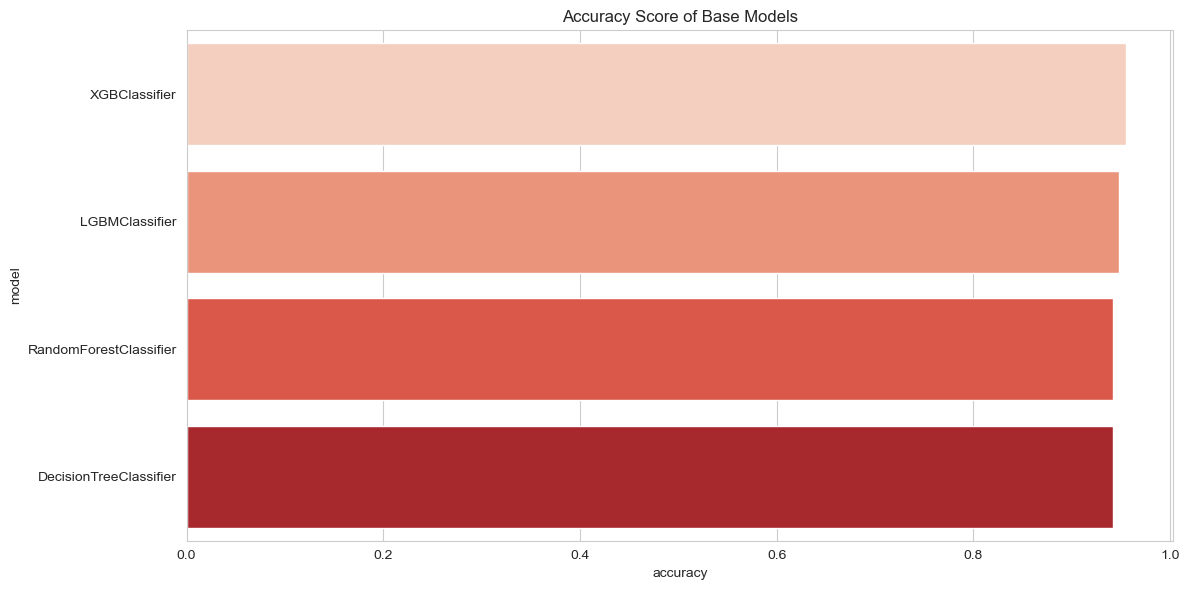

In [95]:
plt.figure(figsize=(12, 6))

sns.barplot(data=base_df, y="model", x="accuracy", palette="Reds")

plt.title("Accuracy Score of Base Models", size=12)

plt.tight_layout()

plt.savefig("../images/base_model_accuracy.jpg", dpi=500)

plt.show()

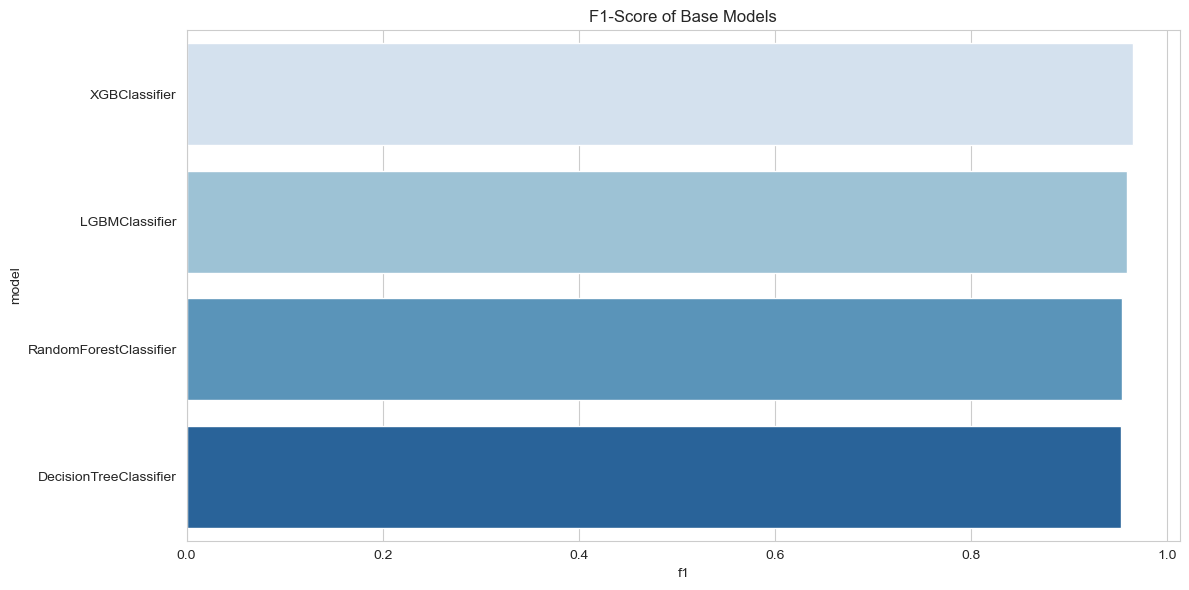

In [96]:
plt.figure(figsize=(12, 6))

sns.barplot(data=base_df, y="model", x="f1", palette="Blues")

plt.title("F1-Score of Base Models", size=12)

plt.tight_layout()

plt.savefig("../images/base_model_f1.jpg", dpi=500)

plt.show()

## HyperParameter Tuning with Optuna

In [25]:
def objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.035, 0.055),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),

    }

    params["random_state"] = 42

    trial_model = xgb.XGBClassifier(**params)
    trial_model.fit(X_train, y_train)
    
    val_pred = trial_model.predict(X_val)
    val_pred_proba = trial_model.predict_proba(X_val)
    val_f1 = f1_score(y_val, val_pred)

    del trial_model
    _ = gc.collect()

    return val_f1

In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_value = study.best_value
best_params = study.best_params

print(f"best score: {best_value}")
print(f"best params: {best_params}")

[I 2024-07-21 20:41:10,905] A new study created in memory with name: no-name-6eb39d7d-c998-4cfe-9d2a-b050a6a67b90
[I 2024-07-21 20:41:11,141] Trial 0 finished with value: 0.9644859813084112 and parameters: {'max_depth': 5, 'learning_rate': 0.050633164443006695, 'subsample': 0.7856196589897828, 'min_child_weight': 10, 'colsample_bytree': 0.5146608635881396}. Best is trial 0 with value: 0.9644859813084112.
[I 2024-07-21 20:41:11,331] Trial 1 finished with value: 0.9608938547486033 and parameters: {'max_depth': 6, 'learning_rate': 0.04530644187677606, 'subsample': 0.6153653415552105, 'min_child_weight': 3, 'colsample_bytree': 0.7524899905404057}. Best is trial 0 with value: 0.9644859813084112.
[I 2024-07-21 20:41:11,547] Trial 2 finished with value: 0.943609022556391 and parameters: {'max_depth': 5, 'learning_rate': 0.03718261158427626, 'subsample': 0.5113627391157707, 'min_child_weight': 2, 'colsample_bytree': 0.5046331655369383}. Best is trial 0 with value: 0.9644859813084112.
[I 2024-0

best score: 0.9684601113172542
best params: {'max_depth': 7, 'learning_rate': 0.04214516436038744, 'subsample': 0.5945489882275804, 'min_child_weight': 3, 'colsample_bytree': 0.7445755872719781}


In [29]:
best_params["random_state"] = 42

best_model = xgb.XGBClassifier(**best_params)

best_model.fit(X_train, y_train)

val_pred = best_model.predict(X_val)
val_pred_proba = best_model.predict_proba(X_val)

val_acc = accuracy_score(y_val, val_pred)
val_auc = roc_auc_score(y_val, val_pred_proba[:, 1])
val_f1 = f1_score(y_val, val_pred)

print(f"best model val_acc: {val_acc:.5f}")
print(f"best model val_auc: {val_auc:.5f}")
print(f"best model val_f1: {val_f1:.5f}")

best model val_acc: 0.96019
best model val_auc: 0.99054
best model val_f1: 0.96846


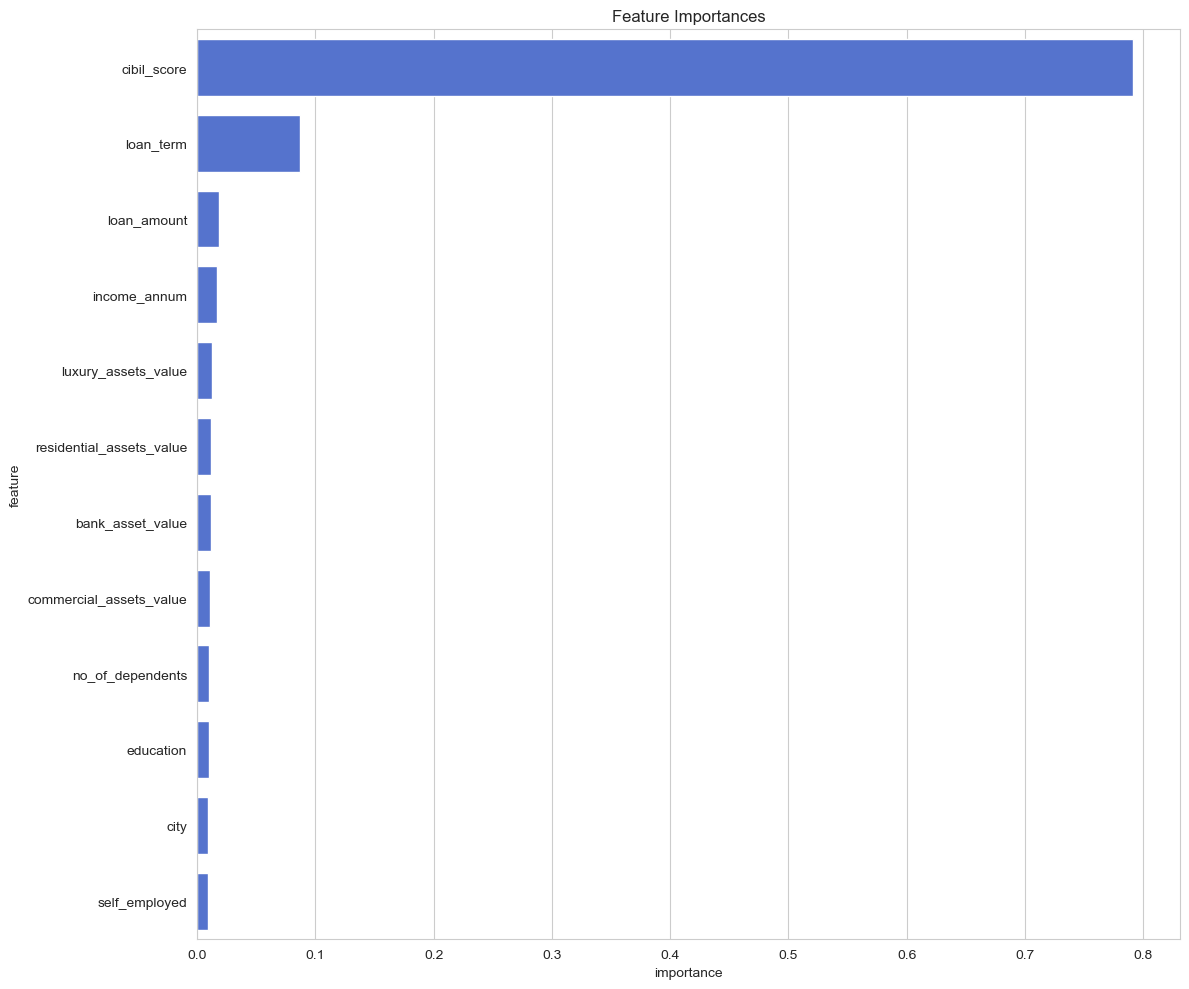

In [107]:
feat_imp_df = pd.DataFrame({"feature": X_train.columns.tolist(), f"importance": best_model.feature_importances_}).sort_values("importance", ascending=False)

plt.figure(figsize=(12, 10))

sns.barplot(
    data=feat_imp_df,
    x="importance",
    y="feature",
    color="royalblue",
    width=0.75
    )

plt.title("Feature Importances", size=12)

plt.tight_layout()

plt.savefig("../images/feature_importances.jpg", dpi=500)

plt.show()

In [41]:
def plot_confusion_matrix(
    cm, classes, title: str, save_path=None, dpi: int = 500
) -> None:

    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title, size=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], ".0f"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.grid(False)
    if save_path is not None:
        plt.savefig(save_path, dpi=dpi)
    plt.show()


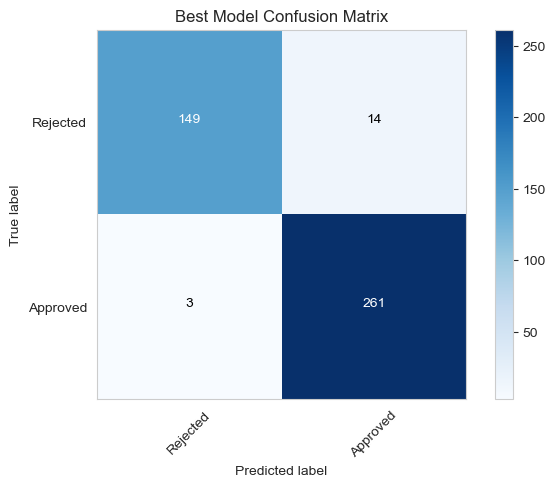

In [42]:
cm = confusion_matrix(y_val, val_pred)

plot_confusion_matrix(cm, classes=["Rejected", "Approved"], title="Best Model Confusion Matrix", save_path="../images/best_model_cm.jpg", dpi=500)

## Saving Best Model

In [30]:
joblib.dump(best_model, '../models/model.pkl')

['../models/model.pkl']